# Data preprocessing

In [51]:
# <api>
import numpy as np
import pandas as pd
import gc

import warnings
warnings.filterwarnings('ignore')

import os
import glob
import os.path as osp
from PIL import Image

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.model_selection import train_test_split

In [52]:
# <api>
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils import data as D

In [53]:
# <api>
# https://github.com/albu/albumentations
from albumentations import (ToFloat, Resize,
    CLAHE, RandomRotate90, Transpose, ShiftScaleRotate, Blur, OpticalDistortion, 
    GridDistortion, HueSaturationValue, IAAAdditiveGaussianNoise, GaussNoise, MotionBlur, 
    MedianBlur, IAAPiecewiseAffine, IAASharpen, IAAEmboss, RandomContrast, RandomBrightness, 
    Flip, OneOf, Compose
)

In [54]:
# <api>
path = '../airbus/'
path_train = path + 'train/'
path_test = path + 'test/'

In [55]:
# <api>
# ref: https://www.kaggle.com/paulorzp/run-length-encode-and-decode
def rle_decode(mask_rle, shape=(768, 768)):
    '''
    mask_rle: run-length as string formated (start length)
    shape: (height,width) of array to return 
    Returns numpy array, 1 - mask, 0 - background

    '''
    s = mask_rle.split()
    starts, lengths = [np.asarray(x, dtype=int) for x in (s[0:][::2], s[1:][::2])]
    starts -= 1
    ends = starts + lengths
    img = np.zeros(shape[0]*shape[1], dtype=np.uint8)
    for lo, hi in zip(starts, ends):
        img[lo:hi] = 1
    return img.reshape(shape).T  # Needed to align to RLE direction

In [56]:
# <api>
# ref: https://www.kaggle.com/leighplt/pytorch-tutorial-dataset-data-preparetion-stage
# ref: https://www.kaggle.com/kmader/transfer-learning-for-boat-or-no-boat
# ref: https://www.kaggle.com/iafoss/fine-tuning-resnet34-on-ship-detection

# This dataset is only for training and validating on TRAIN data, because there was a big failure
# whith the TEST data and it should be updated and uploaded somewhere in the future.
# So this class should be also updated for the submission.
class AirbusDS(object):
    """
    A customized data loader.
    """
    def __init__(self, root, aug=False, resize_factor=1, empty_frac=0.33, test_size=0.1):
        """ Intialize the dataset
        """
        self.filenames = []
        self.root = root
        self.aug = aug
        self.path_train = root + 'train/'
        self.path_test = root + 'test/'
        # TODO: exclude corrupt images
        exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images        
    
        # Calculate masks
        masks = pd.read_csv(str(self.root+'train_ship_segmentations.csv')).fillna(-1)
        masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
        
        # Calculate the number of ships on the images
        unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
        unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
        unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])
        
        # Drop corrupted images
        unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
        
        # Split dataset to train and validate sets to evaluate the model
        train_ids, val_ids = train_test_split(unique_img_ids, test_size=test_size)
        self.val_ids = val_ids
        
        # Drop small images (mostly just clouds, water or corrupted)
        train_ids['file_size_kb'] = train_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)
        train_ids = train_ids[train_ids['file_size_kb']>40] # keep only >40kb files
        
        # Undersample empty images to balance the dataset
        ships = train_ids[train_ids['has_ship']==1] 
        no_ships = train_ids[train_ids['has_ship']==0].sample(frac=empty_frac)  # Take only this fraction of empty images
        self.train_ids = pd.concat([ships, no_ships], axis=0)
        
        masks.drop(['ships'], axis=1, inplace=True)
        self.masks = masks        
        
        # Define transformations for augmentation and without it
        self.transform_no_aug = transforms.Compose([transforms.Resize((int(768/resize_factor), int(768/resize_factor))),
                                                 transforms.ToTensor()])
        if self.aug:
            self.transform = Compose([Resize(height=int(768/resize_factor), width=int(768/resize_factor)),
                                      OneOf([RandomRotate90(), Transpose(), Flip()], p=0.3)])
        else:
            self.transform = self.transform_no_aug                                                 
        
    def get_ds(self):
        return AirbusDS_train(self.path_train, self.aug, self.transform, self.train_ids, self.masks),\
               AirbusDS_val(self.path_train, False, self.transform_no_aug, self.val_ids, self.masks),\
               AirbusDS_test(self.path_test)
    

In [57]:
# <api>
class AirbusDS_train(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path_train, aug, transform, ids, masks):
        """ Intialize the dataset
        """
        self.aug = aug
        self.path_train = path_train
        self.transform = transform
        self.df = ids
        self.masks = masks       
        self.filenames = self.df['ImageId'].values
        self.len = len(self.filenames)
        
    # You must override __getitem__ and __len__
    def get_mask(self, ImageId):
        img_masks = self.masks.loc[self.masks['ImageId'] == ImageId, 'EncodedPixels'].tolist()

        # Take the individual ship masks and create a single mask array for all ships
        all_masks = np.zeros((768, 768))
        if img_masks == [-1]:
            return all_masks
        for mask in img_masks:
            all_masks += rle_decode(mask)
        return all_masks
    
    def get_label(self, ImageId):
        '''Returns a label: 0 - no ship, 1 - has one or more ships.'''
        label = int(self.df[self.df['ImageId']==ImageId]['has_ship'].values[0])
        return label
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
        mask = self.get_mask(ImageId)            
        if self.aug:
            data = {"image": np.array(image), "mask": mask}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, transformed['mask'][np.newaxis,:,:], label
        else:
        
            return self.transform(image), mask[np.newaxis,:,:], label 

    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [58]:
# <api>
class AirbusDS_val(AirbusDS_train):
    """
    A customized data loader.
    """
    
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_train + self.filenames[index]))
        ImageId = self.filenames[index]
        label = self.get_label(ImageId)
                    
        if self.aug:
            data = {"image": np.array(image)}
            transformed = self.transform(**data)
            image = transformed['image']/255
            image = np.transpose(image, (2, 0, 1))
            return image, label
        else:
            return self.transform(image), label

In [59]:
# <api>
class AirbusDS_test(D.Dataset):
    """
    A customized data loader.
    """
    def __init__(self, path_test):
        """ Intialize the dataset
        """
        
        self.path_test = path_test      
        self.test_files = np.array(os.listdir(self.path_test))
        self.len = len(self.test_files)
        
    def __getitem__(self, index):
        """ Get a sample from the dataset
        """       
        
        image = Image.open(str(self.path_test + self.test_files[index]))
        ImageId = self.test_files[index]
        transform = transforms.ToTensor()
        return transform(image), ImageId
    
    def __len__(self):
        """
        Total number of samples in the dataset
        """
        return self.len

In [60]:
# <api>
# functions to show an image
def imshow(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))

# Example of how it works

tensor([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0])


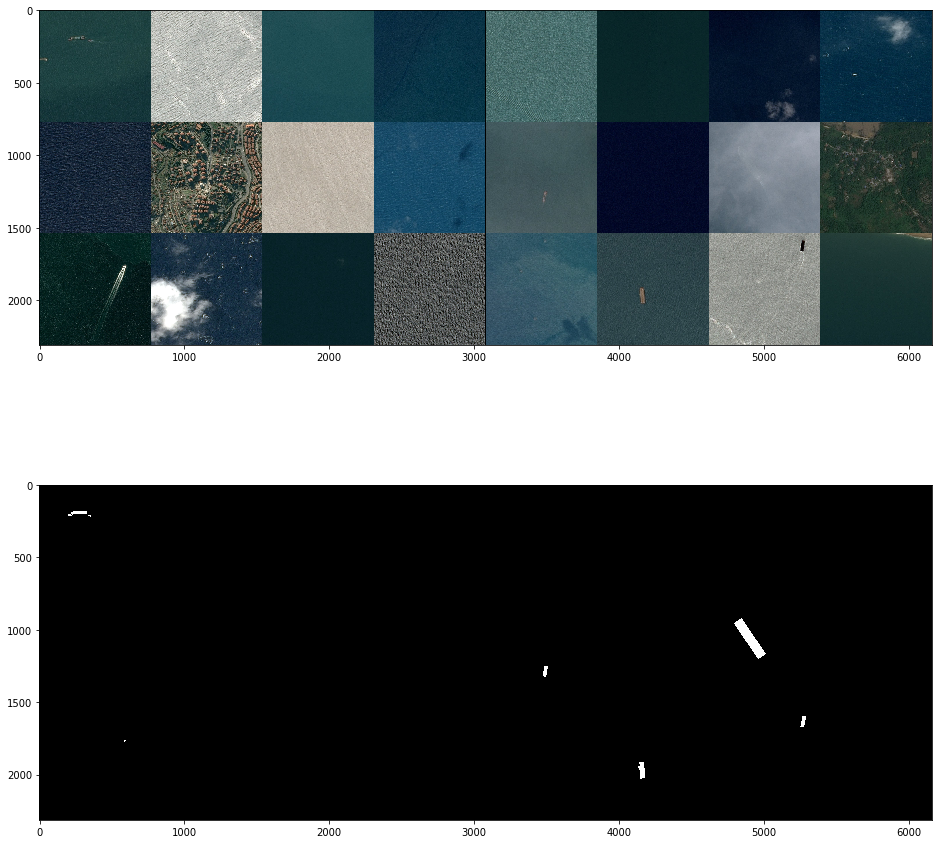

In [61]:
airimg = AirbusDS(path, aug=True, resize_factor=1, empty_frac=0.5, test_size=0.1)
airimg_train, airimg_val, airimg_test = airimg.get_ds()
# Use the torch dataloader to iterate through the dataset
trainloader = D.DataLoader(airimg_train, batch_size=24, shuffle=True, num_workers=0)

# get some images
dataiter = iter(trainloader)
images, masks, labels = dataiter.next()

# show images
plt.figure(figsize=(16,16))
plt.subplot(211)
imshow(torchvision.utils.make_grid(images))
plt.subplot(212)
imshow(torchvision.utils.make_grid(masks))
print(labels)

('72385e3d1.jpg', 'e16a82cf2.jpg', '1aea65d69.jpg', 'f06635a08.jpg', '6da16228e.jpg', '4be7a03a2.jpg', '39b1570c6.jpg', '676ea86eb.jpg')


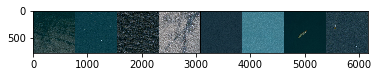

In [62]:
# Use the torch dataloader to iterate through the dataset
testloader = D.DataLoader(airimg_test, batch_size=8, shuffle=True, num_workers=0)

# get some images
dataiter = iter(testloader)
images, img_id = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))

print(img_id)

In [63]:
print('Train size: ', len(airimg_train.filenames))

Train size:  59843


GroundTruth:  tensor([0, 0, 0, 0, 0, 0, 0, 0])
Validation size:  10407


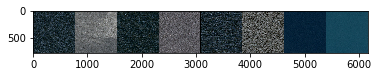

In [64]:
valloader = D.DataLoader(airimg_val, batch_size=8, shuffle=True, num_workers=0)

dataiter = iter(valloader)
images, labels = dataiter.next()

# print images
imshow(torchvision.utils.make_grid(images))
print('GroundTruth: ', labels)
print('Validation size: ', len(airimg_val.filenames))

# Some calculations and histograms from the datset

In [75]:
masks = pd.read_csv(str(path+'train_ship_segmentations.csv'))

In [76]:
masks['ships'] = masks['EncodedPixels'].map(lambda c_row: 1 if isinstance(c_row, str) else 0)
unique_img_ids = masks.groupby('ImageId').agg({'ships': 'sum'}).reset_index()
unique_img_ids['has_ship'] = unique_img_ids['ships'].map(lambda x: 1.0 if x>0 else 0.0)
unique_img_ids['has_ship_vec'] = unique_img_ids['has_ship'].map(lambda x: [x])

In [77]:
unique_img_ids.shape

(104070, 4)

In [78]:
exclude_list = ['6384c3e78.jpg','13703f040.jpg', '14715c06d.jpg',  '33e0ff2d5.jpg',
                '4d4e09f2a.jpg', '877691df8.jpg', '8b909bb20.jpg', 'a8d99130e.jpg', 
                'ad55c3143.jpg', 'c8260c541.jpg', 'd6c7f17c7.jpg', 'dc3e7c901.jpg',
                'e44dffe88.jpg', 'ef87bad36.jpg', 'f083256d8.jpg'] # corrupted images 


In [79]:
unique_img_ids = unique_img_ids[~unique_img_ids['ImageId'].isin(exclude_list)]
unique_img_ids.shape

(104069, 4)

In [80]:
unique_img_ids['file_size_kb'] = unique_img_ids['ImageId'].map(\
                            lambda c_img_id: os.stat(os.path.join(path_train, c_img_id)).st_size/1024)
print(unique_img_ids.shape[0])
unique_img_ids = unique_img_ids[unique_img_ids['file_size_kb']>40] # keep only >40kb files
print(unique_img_ids.shape[0])
ships = unique_img_ids[unique_img_ids['has_ship']==1]
no_ships = unique_img_ids[unique_img_ids['has_ship']==0].sample(frac=1)  #take only frac of empty images
files = pd.concat([ships, no_ships], axis=0)

masks.drop(['ships'], axis=1, inplace=True)

104069
103874


In [71]:
no_ships.shape[0]

74814

In [73]:
ships.shape[0] / no_ships.shape[0] * 100

38.84299729997059

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f84e620c5f8>,
      dtype=object)

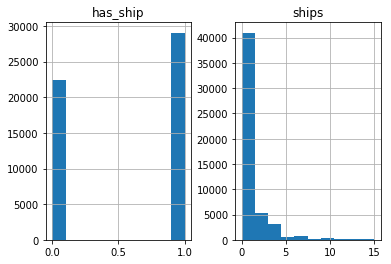

In [20]:
files[['ships', 'has_ship']].hist()

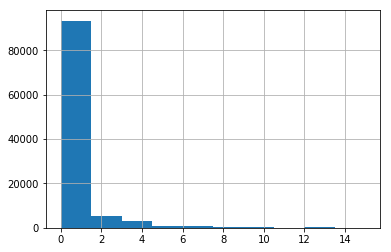

In [74]:
files['ships'].hist()

In [9]:
test_paths = os.listdir(path_test)
print(len(test_paths), 'test images found')

88500 test images found


In [50]:
df1 = pd.DataFrame(columns=['ImageId', 'Label'])
df1.append(pd.DataFrame(np.array([['a','b','c'],[1,2,3]]).T,columns=['ImageId', 'Label']))

,ImageId,Label
0,a,1
1,b,2
2,c,3


In [81]:
126+69

195